In [1]:
#|default_exp n3b7_phate_embedding_experiments
#|export
import numpy as np
import matplotlib.pyplot as plt

# datasets
from diffusion_curvature.datasets import sphere, torus
from sympy import im
from autometric.n0d2_datasets import make_swiss_roll, generate_sine_wave_dataset
from autometric.n0u1_visualization import plot_jacobian, plot_jacobian_multi
from autometric.n0u2_jacobian import compute_jacobian_function

import os
os.environ["GEOMSTATS_BACKEND"] = "pytorch"

# models
import torch
from autometric.autoencoders import DerrickTheAutoencoder
from diffusion_curvature.utils import plot_3d


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 
import matplotlib.style as style
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')
import plotly.express as px


import phate
from phate.mds import embed_MDS
from autometric.geometry import visualize_encoder_pullback_metrics
from autometric.geometry import visualize_encoder_pullback_metrics_in_ambient_space
from autometric.autoencoders import FlexibleDMAutoencoder
# from autometric.autoencoders import CoordinatewiseDistanceMatchingAutoencoder
# from autometric.datasets import train_and_testloader_from_pointcloud_with_distances
# from autometric.datasets import train_and_testloader_from_pointcloud_phate_coords
from autometric.datasets import train_and_testloader_from_flexpc
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

import pathlib

# %load_ext autoreload
# %autoreload 2

/tmp/ipykernel_1938302/1877129053.py:25: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-poster') #sets the size of the charts
INFO: Using pytorch backend


In [15]:
#|export
def run_PHATE_embedding_experiment(
        datasetname,
        phate_decay = 40,
        n_neighbors = 15,
        phate_gamma = 1,
        phate_knn = 15,
        distance_weight = 1,
        reconstruction_weight = 1,
        coordinatewise=False,
        include_pretraining=False,
        savepath = '../data',
        max_epochs = 50,
        plot=False
    ):
    pathlib.Path(savepath).mkdir(parents=True, exist_ok=True)



    if os.path.exists(f"{savepath}/{datasetname}.npy"):
        X = np.load(f"{savepath}/{datasetname}.npy")
        print("Loaded dataset from disk")
    else:
        if datasetname == 'swiss_roll':
            Xs, thetas = make_swiss_roll(turns=2, a=0.1, base_delta_theta=0.1 * 2 * np.pi, theta=1.5 * np.pi, noise=0.)
            ambient_noise = np.random.normal(0, 0.05, size=Xs.shape)
            Xs += ambient_noise
        elif datasetname == 'wavy_sheet':
            Xs = generate_sine_wave_dataset(num_points=2000, amplitude=2, frequencies=(1, 1))
            ambient_noise = np.random.normal(0, 0.05, size=Xs.shape)
            Xs += ambient_noise
        elif datasetname == 'sphere':
            Xs, N = sphere(n=2000, noise=0.05)
        elif datasetname == 'torus':
            Xs, N = torus(n=2000, noise=0.05)
        else:
            raise ValueError(f'Unknown dataset name: {datasetname}')
        X = Xs
        np.save(f"{savepath}/{datasetname}.npy", X)

    if os.path.exists(f"{savepath}/phate_{datasetname}_coords.npy") and os.path.exists(f"{savepath}/phate_{datasetname}_D.npy"):
        phate_coords = np.load(f"{savepath}/phate_{datasetname}_coords.npy")
        phate_D = np.load(f"{savepath}/phate_{datasetname}_D.npy")
        print("Loaded PHATE embedding from disk")
    else:
        print(f"Computing PHATE with {phate_decay=} and {n_neighbors=}")
        phate_op = phate.PHATE(gamma=phate_gamma, knn=phate_knn, random_state=42) #n_components = 2, decay=phate_decay, knn=self.n_neighbors
        phate_coords = phate_op.fit_transform(X)
        phate.plot.scatter2d(phate_coords)
        phate_coordst = torch.tensor(phate_coords)
        phate_D = torch.cdist(phate_coordst, phate_coordst).cpu().detach().numpy()
        np.save(f"{savepath}/phate_{datasetname}_coords.npy", phate_coords)
        np.save(f"{savepath}/phate_{datasetname}_D.npy", phate_D)


    # Create dataloaders
    trainloader, testloader = train_and_testloader_from_flexpc(
        X, # <---- Pointcloud
        phate_coords, # <---- MDS coordinates are actually the PHATE coordinates
        phate_coords, # <---- PHATE coordinates
        phate_D, # <---- Distance matrix to match
        batch_size=64)
    train_sample = next(iter(trainloader))

    # Initialize model and trainer
    model = FlexibleDMAutoencoder(
        input_dim = train_sample['x'].shape[1],
        intrinsic_dim = 2,
        )
    early_stopping = EarlyStopping('val_loss', patience=500)
    trainer = Trainer(
        max_epochs=max_epochs, 
        accelerator='cuda',
        callbacks=[early_stopping],
        use_distributed_sampler=False,
        log_every_n_steps=50,
        )
    if include_pretraining:
        pretrainer = Trainer(
        max_epochs=max_epochs, 
        accelerator='cuda',
        callbacks=[early_stopping],
        use_distributed_sampler=False,
        log_every_n_steps=50,
        )
        model.set_pretrain(distance_weight=distance_weight, reconstruction_weight=distance_weight)
        pretrainer.fit(
            model=model,
            train_dataloaders=trainloader,
            val_dataloaders=testloader,
        )
        stage = 'pretrain'
        model_filename = f"{datasetname}_{distance_weight}_{reconstruction_weight}_{coordinatewise}_{stage}.pt"
        torch.save(model.state_dict(), f'{savepath}/{model_filename}')
        model.set_finetune(distance_weight=distance_weight, reconstruction_weight=reconstruction_weight, coordinatewise=coordinatewise)
        trainer.fit(
            model=model,
            train_dataloaders=trainloader,
            val_dataloaders=testloader,
        )
        stage = 'finetune'
        model_filename = f"{datasetname}_{distance_weight}_{reconstruction_weight}_{coordinatewise}_{stage}.pt"
        torch.save(model.state_dict(), f'{savepath}/{model_filename}')
        print("saved_{model_filename}")
    else:
        stage = 'train'
        model.set_finetune(distance_weight=distance_weight, reconstruction_weight=reconstruction_weight, coordinatewise=coordinatewise)
        trainer.fit(
            model=model,
            train_dataloaders=trainloader,
            val_dataloaders=testloader,
        )
        model_filename = f"{datasetname}_{distance_weight}_{reconstruction_weight}_{coordinatewise}_{stage}.pt"
        torch.save(model.state_dict(), f'{savepath}/{model_filename}')

def plot_PHATE_embedding_experiment(
        datasetname,
        distance_weight = 1,
        reconstruction_weight = 1,
        coordinatewise=False,
        savepath = '../data',
        stage='train',
        **kwargs
):
    if datasetname == 'swiss_roll':
        scale = 0.2
    elif datasetname == 'wavy_sheet':
        scale = 0.5
    elif datasetname == 'sphere':
        scale = 0.2
    elif datasetname == 'torus':
        scale = 0.5
    else:
        print(f'Unknown dataset name: {datasetname}, using default scale 1')
        scale = 1
    X = np.load(f"{savepath}/{datasetname}.npy")
    phate_coords = np.load(f"{savepath}/phate_{datasetname}_coords.npy")
    phate_D = np.load(f"{savepath}/phate_{datasetname}_D.npy")
    # Create dataloaders
    trainloader, testloader = train_and_testloader_from_flexpc(
        X, # <---- Pointcloud
        phate_coords, # <---- MDS coordinates are actually the PHATE coordinates
        phate_coords, # <---- PHATE coordinates
        phate_D, # <---- Distance matrix to match
        batch_size=64)
    train_sample = next(iter(trainloader))
    model_filename = f"{datasetname}_{distance_weight}_{reconstruction_weight}_{coordinatewise}_{stage}.pt"
    model = FlexibleDMAutoencoder(
        input_dim = train_sample['x'].shape[1],
        intrinsic_dim = 2,
        )
    model.load_state_dict(torch.load(f'{savepath}/{model_filename}'))
    visualize_encoder_pullback_metrics(model, trainloader, title = f"PHATE Embedding of {datasetname}")
    visualize_encoder_pullback_metrics_in_ambient_space(model, trainloader, title = f"PHATE Embedding of {datasetname}")

    X_tensor = torch.from_numpy(X).float()
    jac = compute_jacobian_function(model.encoder, X_tensor)
    U, S, V = torch.linalg.svd(jac, full_matrices=False)
    X_enc = model.encoder(X_tensor)

    js = np.random.choice(X.shape[0], size=100)
    plot_jacobian_multi(X_tensor, X_enc, U, V, S, jac, js, scale1=scale)

    enc = model.encoder(X_tensor)
    ground_truth_distances = torch.from_numpy(phate_D).float()
    phate_coords = torch.from_numpy(phate_coords).float()
    if stage == 'pretrain':
        dist_l = model.pretrain_loss(enc, phate_coords)
    elif coordinatewise:
        dist_l = model.distance_loss_coorw(enc, phate_coords)
    else:
        dist_l = model.distance_loss(enc, ground_truth_distances)
    x_hat = model.decoder(enc)
    from torch import nn
    reconstr_l = nn.MSELoss()(x_hat, X_tensor)
    print(f"Distance loss: {dist_l.item():.3f}, Reconstruction loss: {reconstr_l.item():.3f}")

    x_embedded = enc
    embedding_distances = torch.cdist(x_embedded, x_embedded)
    prepared_embedded = (embedding_distances)        
    prepared_truth = (ground_truth_distances)
    dist_l_new = nn.MSELoss()(prepared_embedded, prepared_truth)
    print(dist_l_new.item())

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.scatter(x_embedded.detach().numpy()[:, 0], x_embedded.detach().numpy()[:, 1], c=phate_coords.detach().numpy()[:, 0])
    ax1.set_xlabel('x_embedded[:,0]')
    ax1.set_ylabel('x_embedded[:,1]')
    ax1.set_title('x_embedded colored by phate_coords[:,0]')

    ax2.scatter(x_embedded.detach().numpy()[:, 0], x_embedded.detach().numpy()[:, 1], c=phate_coords.detach().numpy()[:, 1])
    ax2.set_xlabel('x_embedded[:,0]')
    ax2.set_ylabel('x_embedded[:,1]')
    ax2.set_title('x_embedded colored by phate_coords[:,1]')

    plt.suptitle(f'{datasetname}: Comparison of x_embedded and phate_coords, distance loss: {dist_l.item():.2e}, distance MSE: {dist_l_new.item():.2e}')
    plt.tight_layout()
    plt.show()


In [16]:
datasetname = "swiss_roll"
distance_weight = 1
reconstruction_weight = 1
# dist_loss_fn = 'all_coordinates'

run_PHATE_embedding_experiment(
    datasetname,
    distance_weight = distance_weight,
    reconstruction_weight = reconstruction_weight,
    coordinatewise = False,
    include_pretraining = True,
    savepath = '../test',
    max_epochs = 1,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loaded dataset from disk
Loaded PHATE embedding from disk


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 42.3 K
1 | decoder | Sequential | 42.3 K
---------------------------------------
84.6 K    Trainable params
0         Non-trainable params
84.6 K    Total params
0.338     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 42.3 K
1 | decoder | Sequential | 42.3 K
---------------------------------------
84.6 K    Trainable params
0         Non-trainable params
84.6 K    Total params
0.338     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


saved_{model_filename}


In [19]:
datasetname = "swiss_roll"
distance_weight = 1
reconstruction_weight = 1
# dist_loss_fn = 'all_coordinates'

run_PHATE_embedding_experiment(
    datasetname,
    distance_weight = distance_weight,
    reconstruction_weight = reconstruction_weight,
    coordinatewise = False,
    include_pretraining = False,
    savepath = '../test',
    max_epochs = 1,
)

Loaded dataset from disk
Loaded PHATE embedding from disk


/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/autometric/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:191: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_env ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/autometric/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:630: UserWarning:

Checkpoint directory /gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/autometric/nbs/lightning_logs/version_15643970/checkpoints exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Seq

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/autometric/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: PossibleUserWarning:

Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/autometric/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/autometric/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argumen

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


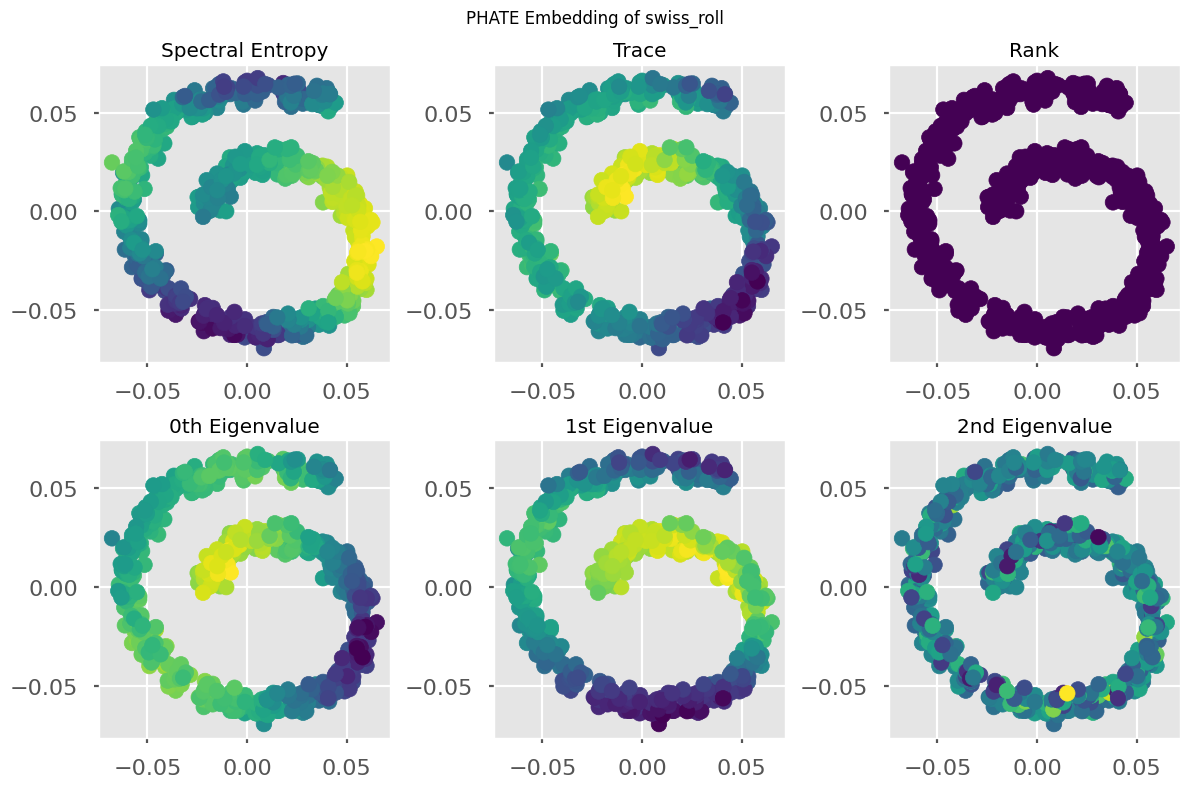

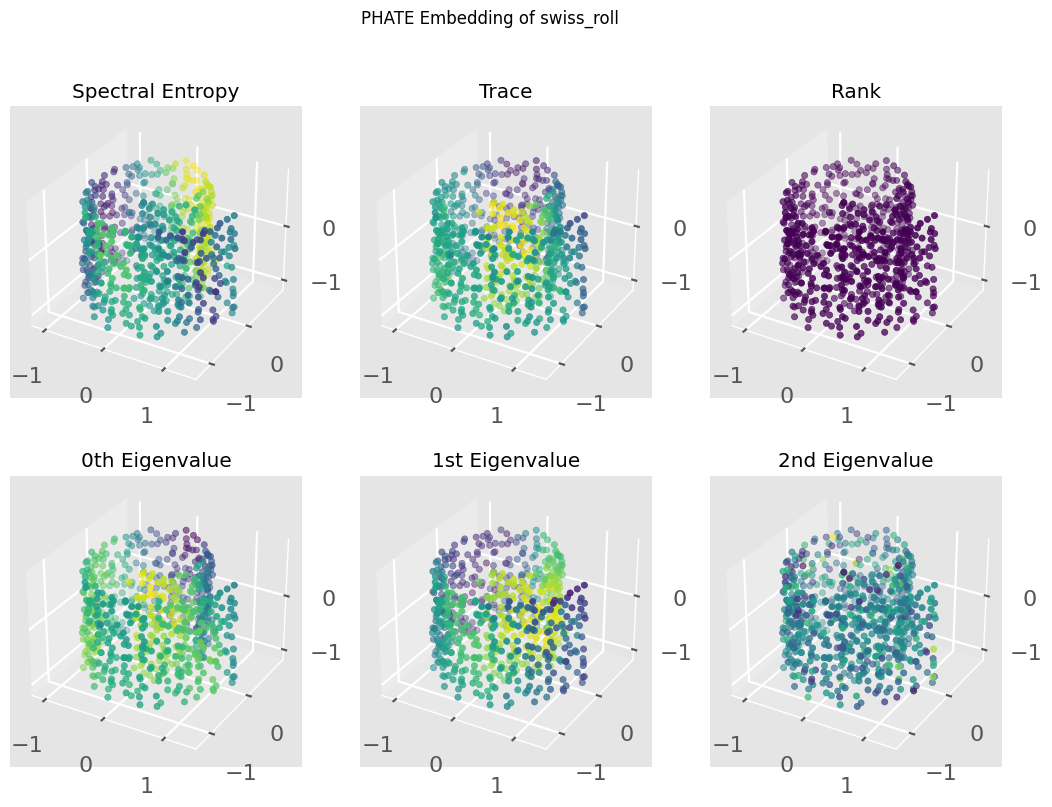

Distance loss: 0.001, Reconstruction loss: 0.164
0.0016866084188222885


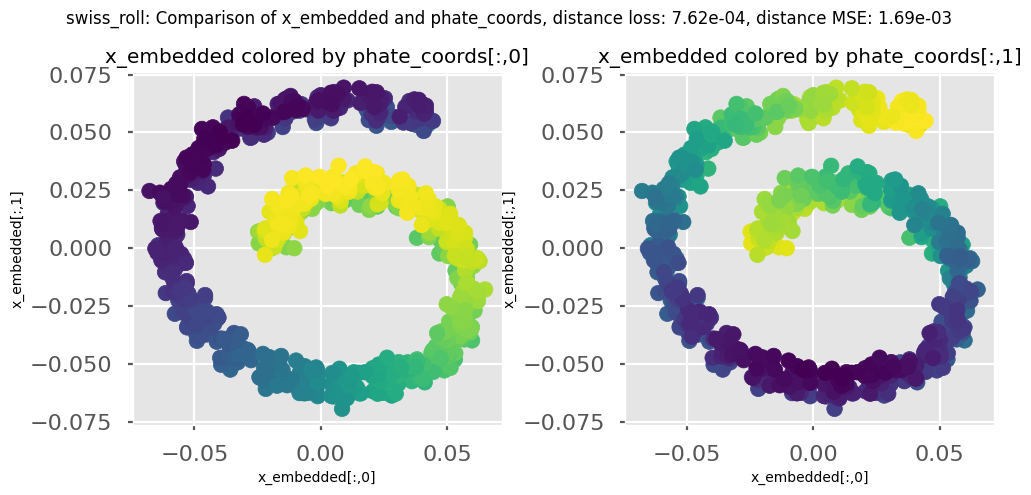

In [17]:
plot_PHATE_embedding_experiment(
    datasetname,
    distance_weight = distance_weight,
    reconstruction_weight = reconstruction_weight,
    coordinatewise = False,
    savepath = '../test',
    stage='pretrain',
    max_epochs = 1,
)

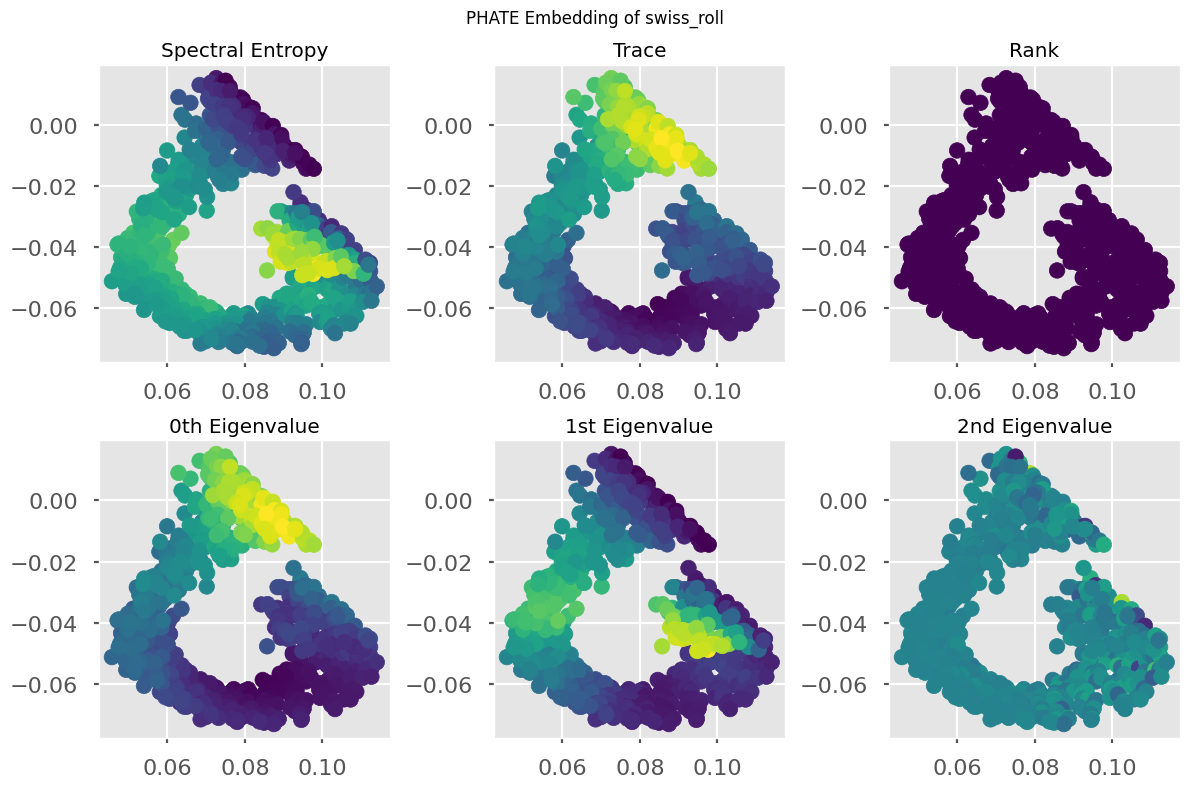

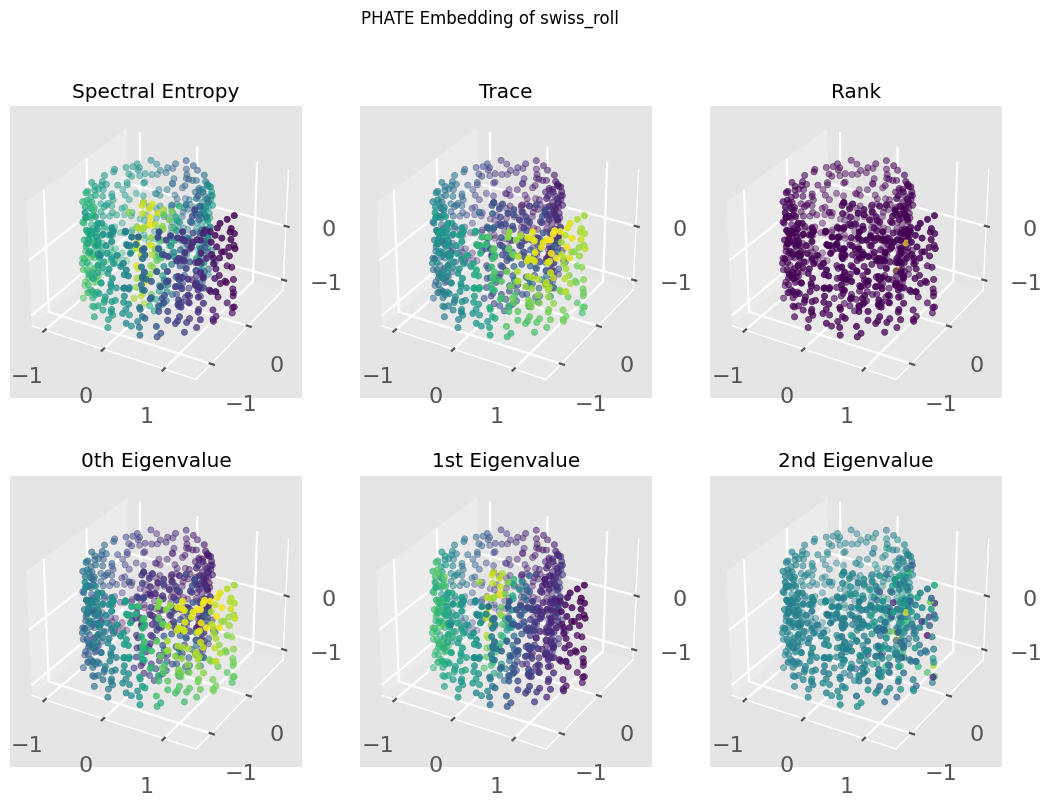

Distance loss: 0.141, Reconstruction loss: 0.216
0.00017658062279224396


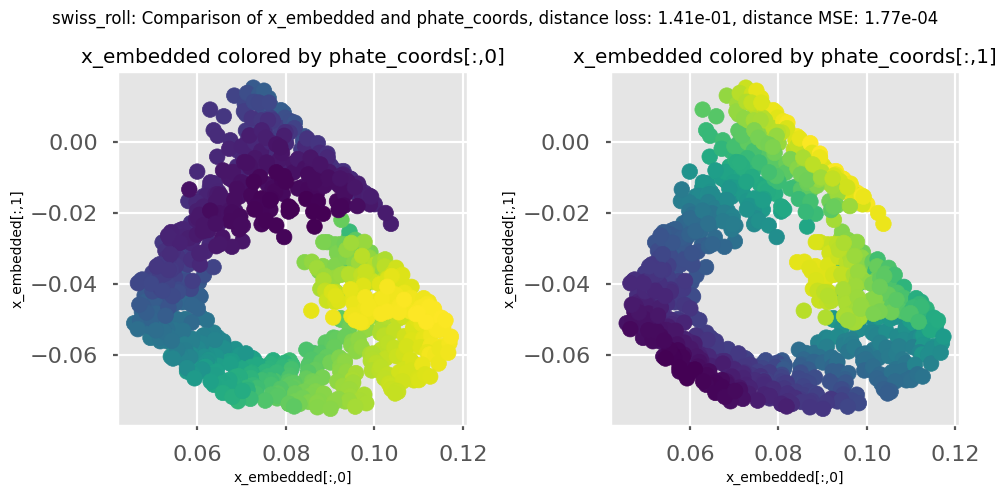

In [18]:
plot_PHATE_embedding_experiment(
    datasetname,
    distance_weight = distance_weight,
    reconstruction_weight = reconstruction_weight,
    coordinatewise = False,
    savepath = '../test',
    stage='finetune',
    max_epochs = 1,
)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/autometric/lib/python3.11/site-packages/torch/_functorch/deprecated.py:88: UserWarning:

We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacfwd is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacfwd instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/autometric/lib/python3.11/site-packages/torch/_functorch/deprecated.py:61: UserWarning:

We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migra

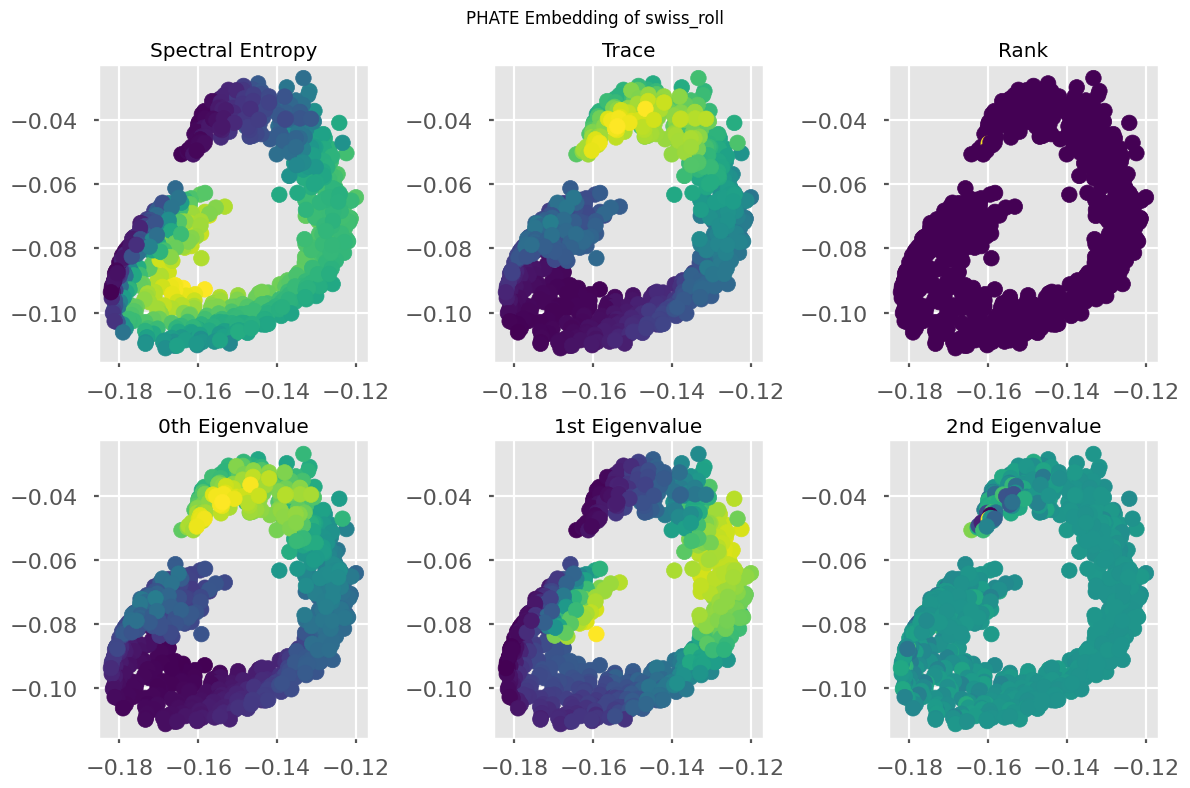

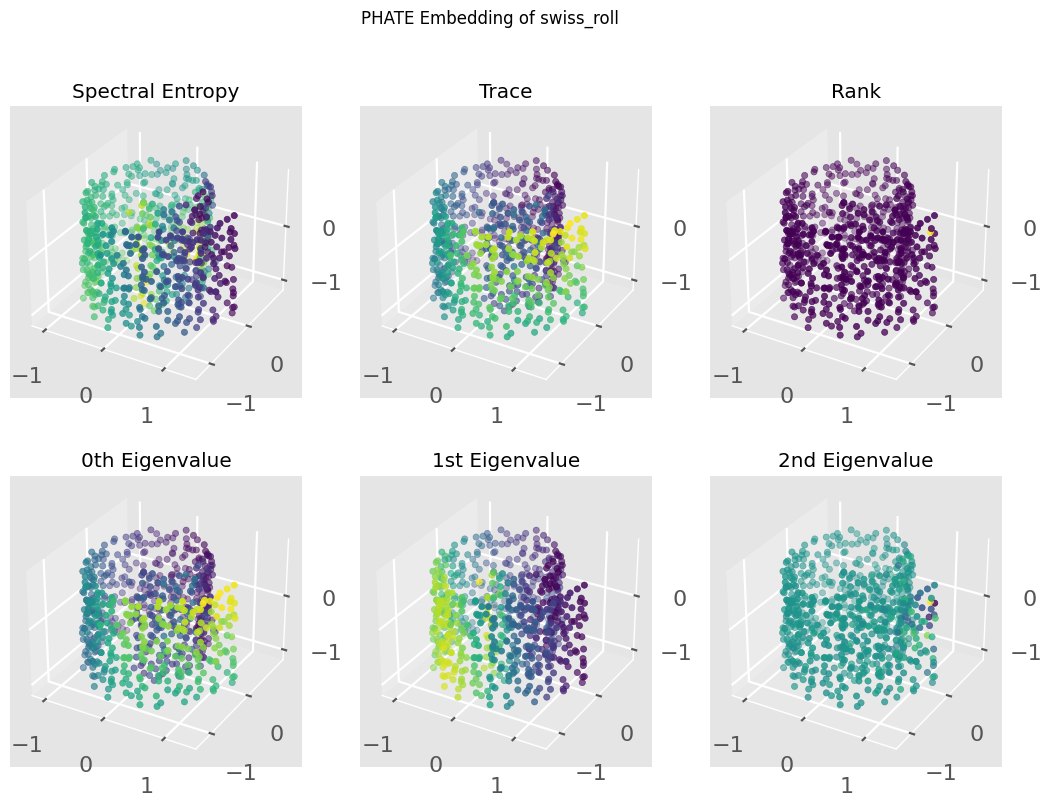

Distance loss: 0.124, Reconstruction loss: 0.197
0.00014738479512743652


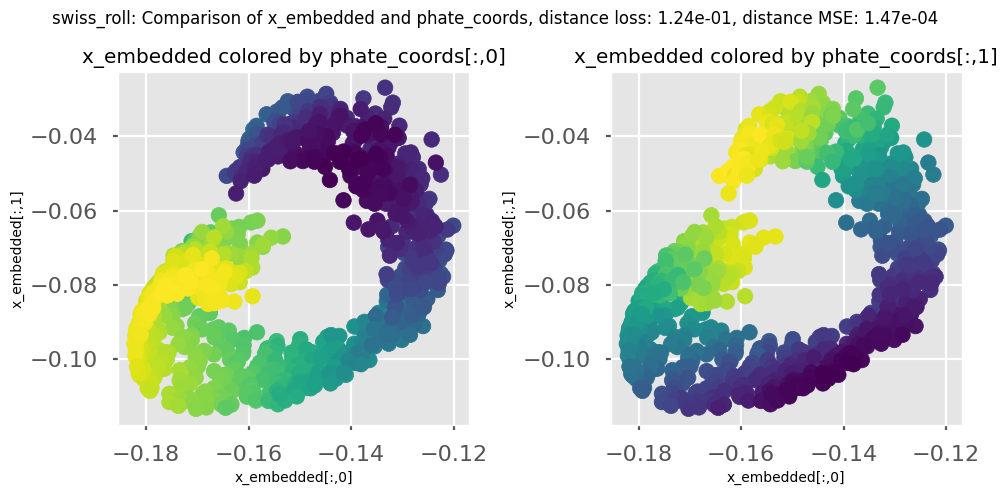

In [20]:
plot_PHATE_embedding_experiment(
    datasetname,
    distance_weight = distance_weight,
    reconstruction_weight = reconstruction_weight,
    coordinatewise = False,
    savepath = '../test',
    stage='train',
    max_epochs = 1,
)

In [5]:
#|hide
import nbdev; nbdev.nbdev_export()